Overview

Customer segmentation involves categorizing your customers into smaller groups based on shared characteristics such as buying habits or demographics. This helps retailers gain deeper insights into their customer base, enabling them to tailor their marketing strategies and products to meet each group's specific needs. 

By employing customer segmentation, companies can enhance customer satisfaction, improve targeting accuracy, and optimize resource allocation, ultimately leading to increased profitability and competitiveness in the market.

In this notebook, we'll explore a few basic customer segmentations. 

### Setup

Here we'll load some simulated data to demonstrate the code. You do not need to know this to perform segmentations.

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_parquet("../../data/transactions.parquet")
df.head()

,transaction_id,transaction_date,customer_id,product_id,product_name,category_0_name,category_0_id,category_1_name,category_1_id,brand_name,brand_id,unit_quantity,unit_spend,store_id
0,7108,2023-01-12 17:44:29,1,15,Spawn Figure,Toys,1,Action Figures,1,McFarlane Toys,3,2,55.98,6
1,7108,2023-01-12 17:44:29,1,1317,Gone Girl,Books,8,Mystery & Thrillers,53,Alfred A. Knopf,264,1,10.49,6
2,4553,2023-02-05 09:31:42,1,509,Ryzen 3 3300X,Electronics,3,Computer Components,21,AMD,102,3,360.00,4
3,4553,2023-02-05 09:31:42,1,735,Linden Wood Paneled Mirror,Home,5,Home Decor,30,Pottery Barn,147,1,599.00,4
4,4553,2023-02-05 09:31:42,1,1107,Pro-V Daily Moisture Renewal Conditioner,Beauty,7,Hair Care,45,Pantene,222,1,4.99,4


Some details about the data

In [ ]:
print(f"Number of unique customers: {df['customer_id'].nunique()}")
print(f"Number of unique transactions: {df['transaction_id'].nunique()}")

Number of unique customers: 4250
Number of unique transactions: 25490


## Heavy / Medium / Light

Heavy, Medium, Light (HML) is a segmentation that places customers into groups based on the their percentile of spend or the number of products they bought. Heavy customers are the top 20% of customers, medium are the next 30%, and light are the bottom 50% of customers. These values are chosen based on the proportions of the Pareto distribution. Often, purchase behaviour follows this distribution. This is typified by the expression 20% of your customers generate 80% of your sales.

You would use a HML segmentation to answer question such as these,

* How much more are your best customers worth?
* How much more could I spend acquiring my best customers?
* What is the concentration of sales with my top (heavy) customers?

Using PyRetailScience it takes only one line of code to get HML segments.

In [ ]:
from pyretailscience.analysis.segmentation import HMLSegmentation

seg = HMLSegmentation(df, zero_value_customers="include_with_light")
seg.df.head()

,unit_spend,segment_name
customer_id,,
4221,2.99,Light
1406,3.49,Light
4094,6.98,Light
3499,8.49,Light
3720,8.50,Light


We can then attach those segments back to the original dataframe. You can see these segments to the very right of the dataframe.

In [ ]:
df_with_segments = seg.add_segment(df)
df_with_segments.head()

,transaction_id,transaction_date,customer_id,product_id,product_name,category_0_name,category_0_id,category_1_name,category_1_id,brand_name,brand_id,unit_quantity,unit_spend,store_id,segment_name
0,7108,2023-01-12 17:44:29,1,15,Spawn Figure,Toys,1,Action Figures,1,McFarlane Toys,3,2,55.98,6,Light
1,7108,2023-01-12 17:44:29,1,1317,Gone Girl,Books,8,Mystery & Thrillers,53,Alfred A. Knopf,264,1,10.49,6,Light
2,4553,2023-02-05 09:31:42,1,509,Ryzen 3 3300X,Electronics,3,Computer Components,21,AMD,102,3,360.00,4,Light
3,4553,2023-02-05 09:31:42,1,735,Linden Wood Paneled Mirror,Home,5,Home Decor,30,Pottery Barn,147,1,599.00,4,Light
4,4553,2023-02-05 09:31:42,1,1107,Pro-V Daily Moisture Renewal Conditioner,Beauty,7,Hair Care,45,Pantene,222,1,4.99,4,Light


Now it's only one line of code to get standard KPIs on each customer segment. This makes segment comparison easy.

In [ ]:
from pyretailscience.analysis.segmentation import SegTransactionStats

seg_stats = SegTransactionStats(df_with_segments, segment_col="segment_name")
seg_stats.df

,segment_name,spend,transactions,customers,units,spend_per_customer,spend_per_transaction,transactions_per_customer,price_per_unit,units_per_transaction,customers_pct
0,Total,8.908818e+07,25490,4250,223950,20961.925033,3495.024770,5.997647,397.803891,8.785798,1.0
1,Light,1.344912e+07,7054,2125,56523,6328.995732,1906.594263,3.319529,237.940589,8.012900,0.5
2,Heavy,4.518138e+07,8572,850,80558,53154.567635,5270.809903,10.084706,560.855315,9.397807,0.2
3,Medium,3.045768e+07,9864,1275,86869,23888.378800,3087.761858,7.736471,350.616249,8.806671,0.3


We can quickly get a bar plot to compare any of the values using the `plot` function. With a few extra lines of code, we can dress up the plot with a callout. Now the chart highlights how much more valuable Heavy customers are compared to the Light ones.

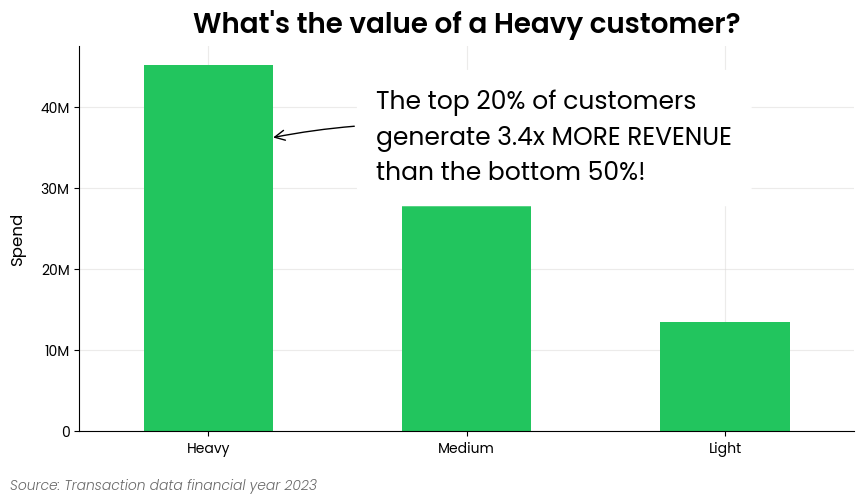

In [ ]:
from pyretailscience.style.graph_utils import GraphStyles

ax = seg_stats.plot(
    figsize=(10, 5),
    value_col="spend",
    source_text="Source: Transaction data financial year 2023",
    sort_order="descending",
    title="What's the value of a Heavy customer?",
    rot=0,
)

# Dress up the plot with an arrow calling out the important point
heavy_rev = seg_stats.df[seg_stats.df["segment_name"] == "Heavy"]["spend"].iat[0]
light_rev = seg_stats.df[seg_stats.df["segment_name"] == "Light"]["spend"].iat[0]
h_vs_l_rev = heavy_rev / light_rev

ax.annotate(
    f"The top 20% of customers\ngenerate {h_vs_l_rev:.1f}x MORE REVENUE\nthan the bottom 50%!",
    xy=(0.24, heavy_rev * 0.8),
    xytext=(0.65, heavy_rev * 0.8),
    fontsize=18,
    fontproperties=GraphStyles.POPPINS_REG,
    ha="left",
    va="center",
    arrowprops={
        "facecolor": "white",
        "arrowstyle": "->",
        "connectionstyle": "arc3,rad=0.1",
    },
    color="black",
    bbox={
        "facecolor": "white",
        "edgecolor": "white",
        "boxstyle": "round,rounding_size=0.75",
        "pad": 0.75,
    },
    linespacing=1.5,
)

plt.savefig("monthly_active_customers.svg")
plt.show()

Getting a plot of the segment's activity over time is also now a snap.

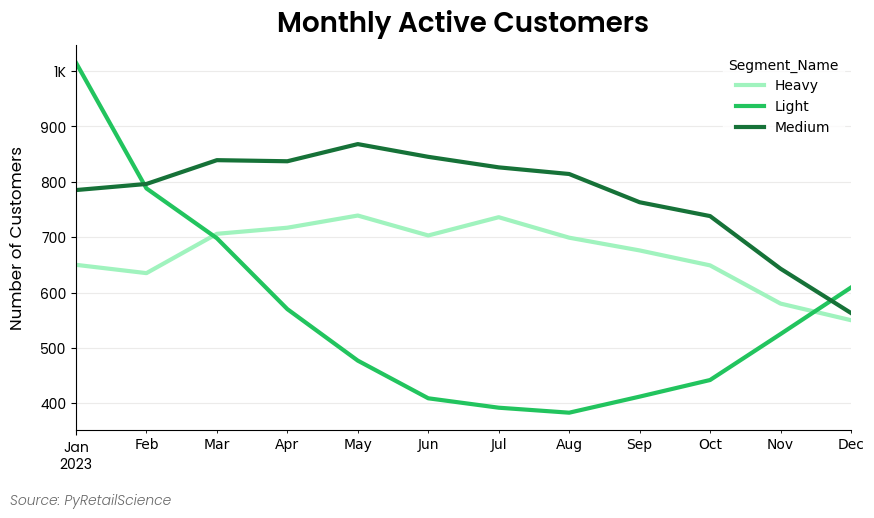

In [ ]:
from pyretailscience.plots.time import plot

df_with_groups = seg.add_segment(df)
plot(
    df_with_groups,
    figsize=(10, 5),
    period="M",
    group_col="segment_name",
    value_col="customer_id",
    agg_func="nunique",
    title="Monthly Active Customers",
    y_label="Number of Customers",
    source_text="Source: PyRetailScience",
)
plt.show()

## Activating

Once you have your segments, you will often want to activate them. It is easy to export them to a CSV for activation in your CRM or with platforms.


In [ ]:
filename = "heavy_customers.csv"
seg.df[seg.df["segment_name"] == "Heavy"].index.to_series().to_csv(filename, index=False)

# Display the CSV
with open(filename) as f:
    print("".join(f.readlines()[:5]))

customer_id
1566
925
2095
1623



## Coming soon

* Quickly segmenting new vs returning customers
* More charting options
* Activating segments to Facebook and other social platforms
* ... and more